In [1]:
import uproot as ur
import awkward as ak
import numpy as np

data_path = '/fast_scratch/atlas_images/v01-45/'

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('/Users/swiatlow/Code/ML4P/LCStudies')
sys.path.append('/home/mswiatlowski/start_tf/LCStudies')
import graph_util as gu
import plot_util as pu

path_pipm = data_path + 'pipm_medium.root'
path_pi0  = data_path + 'pi0_medium.root'


In [3]:
import convert_sets

Working on /fast_scratch/atlas_images/v01-45/pipm_medium.root
Loading data
eta [-1.125384   -0.9594247   0.93537796 -1.9522849   1.1632881  -0.06523713
 -0.05172568 -0.09848271 -0.03274849  1.0723295 ]
Normalizing


/home/kaelaekd/start_tf/LCStudies/classifier/convert_sets.py:65: RuntimeWarning: divide by zero encountered in log
  cell_e = np.nan_to_num(np.log(cell_e), posinf = 0, neginf=0)


Writing out


/home/kaelaekd/start_tf/LCStudies/classifier/convert_sets.py:78: RuntimeWarning: divide by zero encountered in log
  Y_target = np.log(clus_targetE[selection]) #for regression, I don't need
/home/kaelaekd/start_tf/LCStudies/classifier/convert_sets.py:78: RuntimeWarning: invalid value encountered in log
  Y_target = np.log(clus_targetE[selection]) #for regression, I don't need


Done! /fast_scratch/atlas_images/v01-45/pipm_medium.npz
Working on /fast_scratch/atlas_images/v01-45/pi0_medium.root
Loading data
eta [ 2.6569927   2.2744625   2.267206   -0.17188169 -2.7659993  -2.178036
 -2.1792655  -2.2079153  -2.125493   -2.0137668 ]
Normalizing
Writing out
Done! /fast_scratch/atlas_images/v01-45/pi0_medium.npz


In [4]:
pipm_med = np.load('/fast_scratch/atlas_images/v01-45/pipm_medium.npz')
pi0_med = np.load('/fast_scratch/atlas_images/v01-45/pi0_medium.npz')

In [5]:
pipm_med.files

['X', 'Y_label', 'Y_target', 'clus_eta']

In [6]:
X_pipm = pipm_med['X']
X_pi0 = pi0_med['X']

Y_label_pipm = pipm_med['Y_label']
Y_label_pi0 = pi0_med['Y_label']

clus_eta_pipm = pipm_med['clus_eta']
clus_eta_pi0 = pi0_med['clus_eta']

In [7]:
pipm_med['Y_label']

array([1., 1., 1., ..., 1., 1., 1.])

In [8]:
selec_pipm = (abs(clus_eta_pipm) > 2.5) & (abs(clus_eta_pipm) < 3.1)
selec_pi0  = (abs(clus_eta_pi0) > 2.5) & (abs(clus_eta_pi0) < 3.1)


In [9]:
len(clus_eta_pipm), X_pipm.shape

(592857, (592857, 2000, 4))

In [10]:
X_pipm_selec = X_pipm[selec_pipm]
X_pi0_selec = X_pi0[selec_pi0]

In [11]:
Y_label_pipm_selec = Y_label_pipm[selec_pipm]
Y_label_pi0_selec = Y_label_pi0[selec_pi0]

clus_eta_pipm_selec = clus_eta_pipm[selec_pipm]
clus_eta_pi0_selec = clus_eta_pi0[selec_pi0]

In [12]:
len(X_pipm_selec), len(X_pi0_selec)

(39324, 36328)

In [13]:
Y_label_pi0.shape, Y_label_pipm.shape

((395440,), (592857,))

In [14]:
Y_label_pi0_selec, Y_label_pipm

(array([0., 0., 0., ..., 0., 0., 0.]), array([1., 1., 1., ..., 1., 1., 1.]))

In [15]:
X = np.concatenate((X_pipm_selec[:36000], X_pi0_selec[:36000]))
Y = tf.keras.utils.to_categorical(np.concatenate((Y_label_pipm_selec[:36000],Y_label_pi0_selec[:36000])))
#Y = tf.keras.utils.to_categorical(np.concatenate((np.ones(36000), np.zeros(36000))))
X.shape, Y.shape #either of these two Y definitions does the same thing, so that can't be the issue

((72000, 2000, 4), (72000, 2))

In [16]:
def modelNmetrics(X, Y, batch_size, test_size):
    Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
    print('sizes: X ', len(X), 'Y: ', len(Y))
    # do train/val/test split 
    (X_train, X_val, X_test, Y_train, Y_val, Y_test) = data_split(X, Y, val=10000, test=test_size)
    print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)
    #make the model:
    pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)#, num_global_features =1)
    
    #try callbacks:
    callback = tf.keras.callbacks.ModelCheckpoint('./w6_pfn1', save_best_only=True)
    
    # train model
    history = pfn.fit(X_train, Y_train, epochs=200, batch_size=batch_size, validation_data=(X_val, Y_val), verbose=1, callbacks=[callback])
    
    preds = pfn.predict(X_test, batch_size=1000)
    pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])
    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print('PFN AUC:', auc)
   
    return history, pfn_fp, pfn_tp, auc

In [17]:
def plots(history, pfn_fp, pfn_tp, auc):
    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=[12,6])
    ax1.set_xlim(0,len(history.history['acc']))
    ax1.plot(history.history['acc'], label='training set', c='xkcd:butterscotch', linewidth=3)
    ax1.plot(history.history['val_acc'], label='test set', c='xkcd:coffee', linewidth=3)
    ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend()

    ax2.set_xlim(0,len(history.history['acc']))
    ax2.plot(history.history['loss'], label='training set', c='xkcd:dull brown', linewidth=3)
    ax2.plot(history.history['val_loss'], label='test set', c='xkcd:taupe', linewidth=3)
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.set_yscale('log')
    ax2.legend()
    
    plt.figure(figsize=[7,7])
    plt.xlim(-.01,1.01)
    plt.ylim(-.01,1.01)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(pfn_fp, pfn_tp, c='xkcd:dirt', linewidth=4, label='AUC = %.3f'%auc)
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')
    plt.legend()

In [18]:
history_b2531, fp_2531, tp_2531, auc_2531 = modelNmetrics(X, Y, 1000, 20000)
#okay so now that script is working! thats part 1 done, I'm gonna try for 2 and 4 here as well and 3 perhaps
#so this was without callbacks

sizes: X  72000 Y:  72000
(42000, 2000, 4) (10000, 2000, 4) (20000, 2000, 4) (42000, 2) (10000, 2) (20000, 2)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation[0][0]  

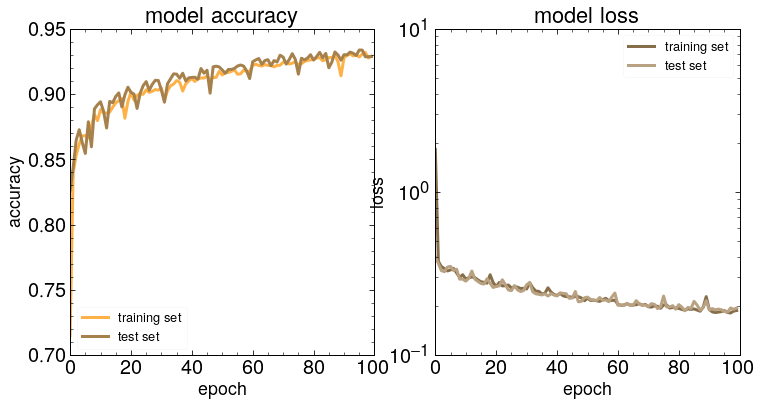

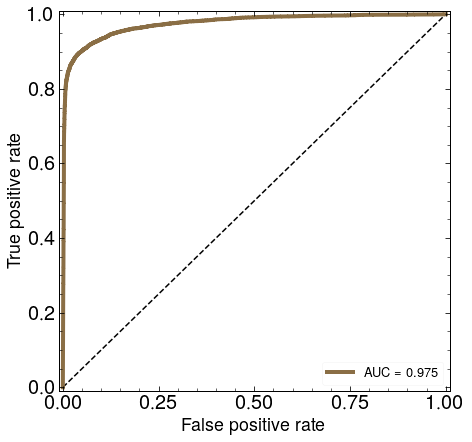

In [21]:
plots(history_b2531, fp_2531, tp_2531, auc_2531)

In [26]:
history_b2531_2, fp_2531_2, tp_2531_2, auc_2531_2 = modelNmetrics(X, Y, 1000, 20000) #tried adding the callback 

sizes: X  72000 Y:  72000
(42000, 2000, 4) (10000, 2000, 4) (20000, 2000, 4) (42000, 2) (10000, 2) (20000, 2)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_14 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_14[0]

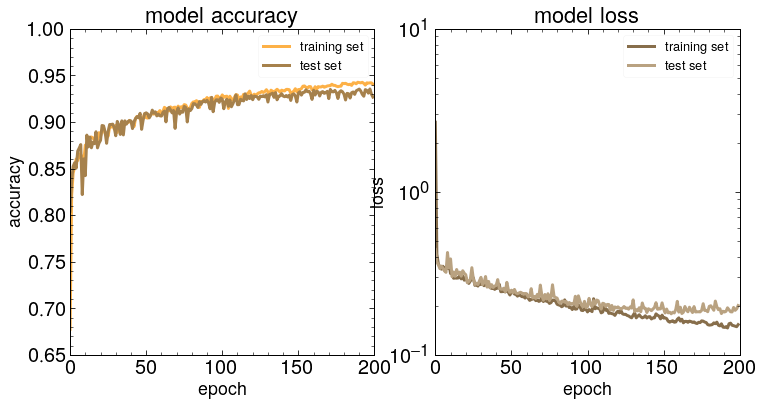

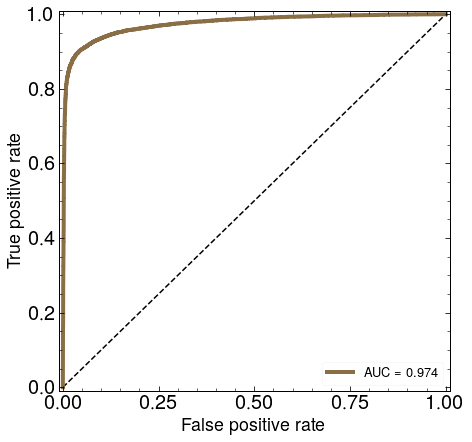

In [27]:
plots(history_b2531_2, fp_2531_2, tp_2531_2, auc_2531_2) #okay the callback worked but I'm not sure what to do with it???

In [28]:
len(X_pipm), len(X_pi0)

(592857, 395440)

In [18]:
# now for step 3:

X_all = np.concatenate((X_pipm[:390000], X_pi0[:390000]))
Y_all = tf.keras.utils.to_categorical(np.concatenate((Y_label_pipm[:390000],Y_label_pi0[:390000])))


In [45]:
x_all_small = np.concatenate((X_pipm[:39000], X_pi0[:39000]))
y_all_small = tf.keras.utils.to_categorical(np.concatenate((Y_label_pipm[:39000],Y_label_pi0[:39000])))
eta_small = np.concatenate((clus_eta_pipm[:39000], clus_eta_pi0[:39000]))

In [19]:
eta = np.concatenate((clus_eta_pipm[:390000], clus_eta_pi0[:390000]))

In [20]:
#define the different eta regions ACTUALLY this isn't needed
selec_pipm_l07 = abs(clus_eta_pipm) < 0.7
selec_pi0_l07 = abs(clus_eta_pi0) < 0.7

selec_pipm_b0714 = (abs(clus_eta_pipm) >= .7) & (abs(clus_eta_pipm) < 1.4)
selec_pi0_b0714 = (abs(clus_eta_pi0) >= .7) & (abs(clus_eta_pi0) < 1.4)

selec_pipm_b1425 = (abs(clus_eta_pipm) >= 1.4) & (abs(clus_eta_pipm) < 2.5)
selec_pi0_b1425 = (abs(clus_eta_pi0) >= 1.4) & (abs(clus_eta_pi0) < 2.5)

selec_pipm_b2531 = (abs(clus_eta_pipm) >= 2.5) & (abs(clus_eta_pipm) < 3.1)
selec_pi0_b2531  = (abs(clus_eta_pi0) >= 2.5) & (abs(clus_eta_pi0) < 3.1)

selec_pipm_g31 = abs(clus_eta_pipm) >= 3.1
selec_pi0_g31 = abs(clus_eta_pi0) >= 3.1

selections = [selec_pipm_l07, selec_pi0_l07, selec_pipm_b0714, selec_pi0_b0714, selec_pipm_b1425, selec_pi0_b1425, selec_pipm_b2531, selec_pi0_b2531, selec_pipm_g31, selec_pi0_g31]

In [50]:
def modelNmetrics_all(X, Y, eta, batch_size, test_size):
    Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
    print('sizes: X ', len(X), 'Y: ', len(Y))
    # do train/val/test split 
    (X_train, X_val, X_test, Y_train, Y_val, Y_test, eta_train, eta_val, eta_test) = data_split(X, Y, eta, val=10000, test=test_size)
    print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)
    #make the model:
    pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)#, num_global_features =1)
    
    #try callbacks:
    callback = tf.keras.callbacks.ModelCheckpoint('./w6_pfn1', save_best_only=True)
    
    # train model
    history = pfn.fit(X_train, Y_train, epochs=200, batch_size=batch_size, validation_data=(X_val, Y_val), verbose=1, callbacks=[callback])
    
    #define the different eta regions
    selec_l07 = abs(eta_test) < 0.7
    selec_b0714 = (abs(eta_test) >= .7) & (abs(eta_test) < 1.4)
    selec_b1425 = (abs(eta_test) >= 1.4) & (abs(eta_test) < 2.5)
    selec_b2531 = (abs(eta_test) >= 2.5) & (abs(eta_test) < 3.1) #max eta is 3 so!!
    #selec_g31 = abs(eta_test) >= 3.1 
    
    selections = [selec_l07, selec_b0714, selec_b1425, selec_b2531]
    
    fps = []
    tps = []
    threshss = []
    aucs = []
    for selection in selections:
        #print(X_test[selection])
        preds = pfn.predict(X_test[selection], batch_size=1000)
        pfn_fp, pfn_tp, threshs = roc_curve(Y_test[selection][:,1], preds[:,1])
        
        fps.append(pfn_fp)
        tps.append(pfn_tp)
        threshss.append(threshs)
        # get area under the ROC curve
        auc = roc_auc_score(Y_test[selection][:,1], preds[:,1])
        aucs.append(auc)
        print('PFN AUC:', auc)
   
    return history, fps, tps, aucs, selections

In [51]:
history_all, fp_all, tp_all, auc_all, selecs = modelNmetrics_all(x_all_small, y_all_small, eta_small, 1000, 10000)

sizes: X  78000 Y:  78000
(58000, 2000, 4) (10000, 2000, 4) (10000, 2000, 4) (58000, 2) (10000, 2) (10000, 2)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_21 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_21[0]

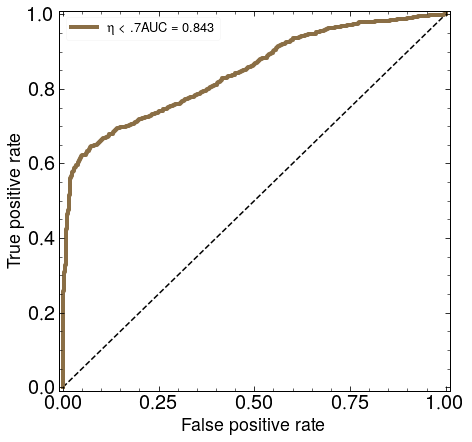

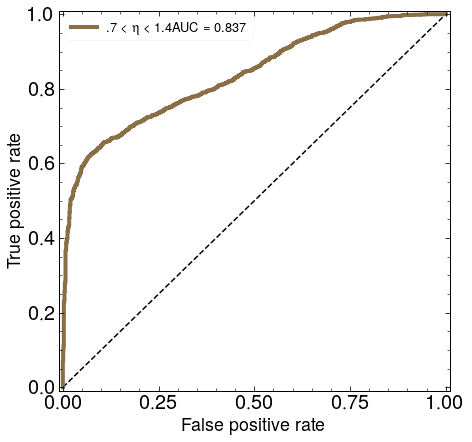

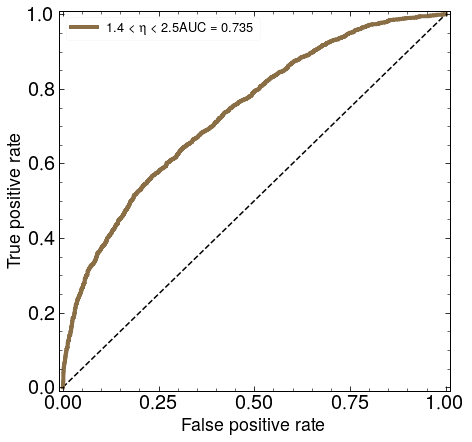

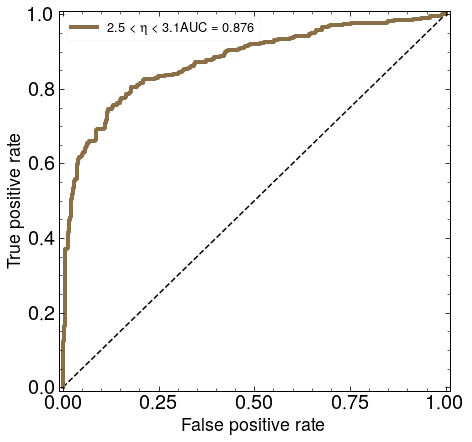

In [49]:
labs = ['$\eta$ < .7', '.7 < $\eta$ < 1.4', '1.4 < $\eta$ < 2.5', '2.5 < $\eta$ < 3.1']

for i in range(len(fp_all)):

    plt.figure(figsize=[7,7])
    plt.xlim(-.01,1.01)
    plt.ylim(-.01,1.01)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fp_all[i], tp_all[i], c='xkcd:dirt', linewidth=4, label=labs[i] + 'AUC = %.3f '%auc_all[i])
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')
    plt.legend() #this was for two epochs, with a smaller selection of all eta because it took FOREVER with a 
    #larger selection. so at least it works

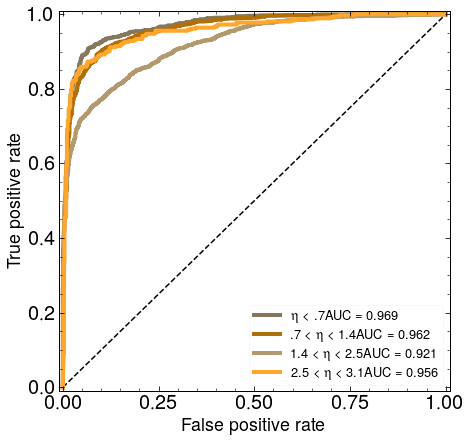

In [52]:
#now run for 200 epochs with same smaller sample, plot all together!

plt.figure(figsize=[7,7])
plt.xlim(-.01,1.01)
plt.ylim(-.01,1.01)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fp_all[0], tp_all[0], c='xkcd:brownish grey', linewidth=4, label=labs[0] + 'AUC = %.3f '%auc_all[0])
plt.plot(fp_all[1], tp_all[1], c='xkcd:caramel', linewidth=4, label=labs[1] + 'AUC = %.3f '%auc_all[1])
plt.plot(fp_all[2], tp_all[2], c='xkcd:dust', linewidth=4, label=labs[2] + 'AUC = %.3f '%auc_all[2])
plt.plot(fp_all[3], tp_all[3], c='xkcd:mango', linewidth=4, label=labs[3] + 'AUC = %.3f '%auc_all[3])
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend() 

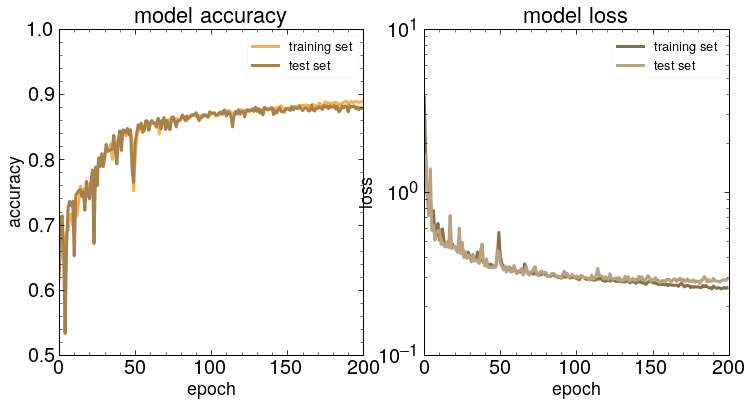

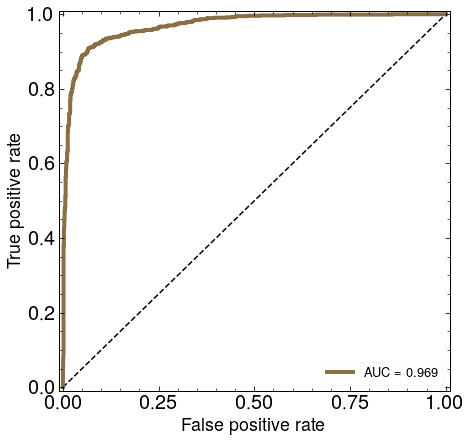

In [55]:
plots(history_all, fp_all[0], tp_all[0], auc_all[0])

In [72]:
#putting it all together:

def modelNmetrics_complete(X_cell, X_glob, Y, eta, epochs, batch_size, val_size, test_size):
    Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
    print('sizes: X ', len(X_cell), 'Y: ', len(Y))
    
    # do train/val/test split 
    (X_train, X_val, X_test, Y_train, Y_val, Y_test, X_glob_tr, X_glob_val, X_glob_te, eta_train, eta_val, eta_test) = data_split(X_cell, Y, X_glob, eta, val=val_size, test=test_size)
    print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)
    
    #concatenate the Xs:
    X_tr = [X_train, X_glob_tr]
    X_vali = [X_val, X_glob_val]
    X_te = [X_test, X_glob_te]
    
    #make the model:
    pfn = PFN(input_dim=X_cell.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes, num_global_features =1)
    
    #try callbacks:
    callback = tf.keras.callbacks.ModelCheckpoint('./w6_pfn4.hdf5', save_best_only=True)
    
    # train model
    history = pfn.fit(X_tr, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_vali, Y_val), verbose=1, callbacks=[callback])
    
    #define the different eta regions
    selec_l07 = abs(eta_test) < 0.7
    selec_b0714 = (abs(eta_test) >= .7) & (abs(eta_test) < 1.4)
    selec_b1425 = (abs(eta_test) >= 1.4) & (abs(eta_test) < 2.5)
    selec_b2531 = (abs(eta_test) >= 2.5) & (abs(eta_test) < 3.1) #max eta is 3 so!!
    selec_all = abs(eta_test) <= 3.1 
    
    selections = [selec_l07, selec_b0714, selec_b1425, selec_b2531, selec_all]
    
    X_1, X_2 = X_te
    fps = []
    tps = []
    threshss = []
    aucs = []
    for selection in selections:
        #print(X_test[selection])
        
        X_interm = [X_1[selection], X_2[selection]] #YAY got it working!! just had to split it up to make the selection
        preds = pfn.predict(X_interm, batch_size=1000) 
        pfn_fp, pfn_tp, threshs = roc_curve(Y_test[selection][:,1], preds[:,1])
        
        fps.append(pfn_fp)
        tps.append(pfn_tp)
        threshss.append(threshs)
        # get area under the ROC curve
        auc = roc_auc_score(Y_test[selection][:,1], preds[:,1])
        aucs.append(auc)
        print('PFN AUC:', auc)
   
    return history, fps, tps, aucs, selections

In [69]:
X_glob = np.concatenate((clus_eta_pipm[:390000], clus_eta_pi0[:390000]))

In [73]:
history_all, fp_all, tp_all, auc_all, selecs = modelNmetrics_complete(X_all, X_glob, Y_all, eta, 200, 1000, 100000, 100000)

sizes: X  780000 Y:  780000
(580000, 2000, 4) (100000, 2000, 4) (100000, 2000, 4) (580000, 2) (100000, 2) (100000, 2)
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_42 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activati

In [76]:
def plots_complete(history, fp_all, tp_all, auc_all):
    labs = ['$\eta$ < .7', '.7 < $\eta$ < 1.4', '1.4 < $\eta$ < 2.5', '2.5 < $\eta$ < 3.1', 'all $\eta$']
    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=[12,6])
    ax1.set_xlim(0,len(history.history['acc']))
    ax1.plot(history.history['acc'], label='training set', c='xkcd:butterscotch', linewidth=3)
    ax1.plot(history.history['val_acc'], label='test set', c='xkcd:coffee', linewidth=3)
    ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend()

    ax2.set_xlim(0,len(history.history['acc']))
    ax2.plot(history.history['loss'], label='training set', c='xkcd:dull brown', linewidth=3)
    ax2.plot(history.history['val_loss'], label='test set', c='xkcd:taupe', linewidth=3)
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.set_yscale('log')
    ax2.legend()
    
    fig2, (ax3, ax4) = plt.subplots(1,2, figsize=[12,6])
    
    ax3.set_xlim(-.01,1.01)
    ax3.set_ylim(-.01,1.01)
    ax3.plot([0, 1], [0, 1], 'k--')
    ax3.plot(fp_all[0], tp_all[0], c='xkcd:brownish grey', linewidth=4, label=labs[0] + 'AUC = %.3f '%auc_all[0])
    ax3.plot(fp_all[1], tp_all[1], c='xkcd:caramel', linewidth=4, label=labs[1] + 'AUC = %.3f '%auc_all[1])
    ax3.plot(fp_all[2], tp_all[2], c='xkcd:dust', linewidth=4, label=labs[2] + 'AUC = %.3f '%auc_all[2])
    ax3.plot(fp_all[3], tp_all[3], c='xkcd:mango', linewidth=4, label=labs[3] + 'AUC = %.3f '%auc_all[3])
    ax3.plot(fp_all[4], tp_all[4], c='xkcd:brown', linewidth=4, label=labs[4] + 'AUC = %.3f '%auc_all[4])
    ax3.set_ylabel('True positive rate')
    ax3.set_xlabel('False positive rate')
    ax3.legend() 
    
    ax4.set_xlim(-.01,.4)
    ax4.set_ylim(.6,1.01)
    ax4.plot([0, 1], [0, 1], 'k--')
    ax4.plot(fp_all[0], tp_all[0], c='xkcd:brownish grey', linewidth=4, label=labs[0] + 'AUC = %.3f '%auc_all[0])
    ax4.plot(fp_all[1], tp_all[1], c='xkcd:caramel', linewidth=4, label=labs[1] + 'AUC = %.3f '%auc_all[1])
    ax4.plot(fp_all[2], tp_all[2], c='xkcd:dust', linewidth=4, label=labs[2] + 'AUC = %.3f '%auc_all[2])
    ax4.plot(fp_all[3], tp_all[3], c='xkcd:mango', linewidth=4, label=labs[3] + 'AUC = %.3f '%auc_all[3])
    ax4.plot(fp_all[4], tp_all[4], c='xkcd:brown', linewidth=4, label=labs[4] + 'AUC = %.3f '%auc_all[4])
    ax4.set_ylabel('True positive rate')
    ax4.set_xlabel('False positive rate')
    ax4.legend() 

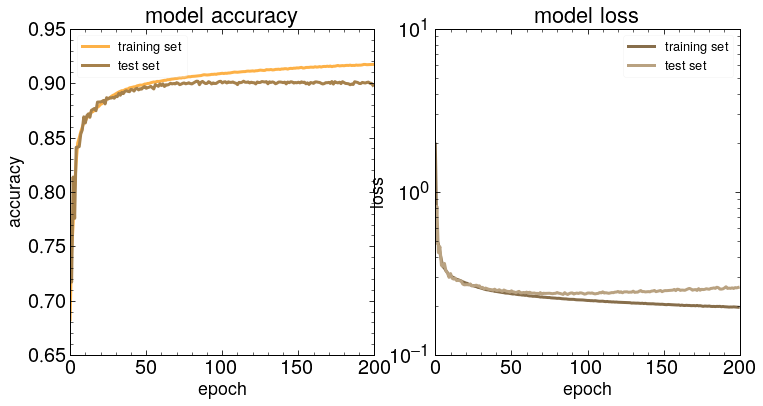

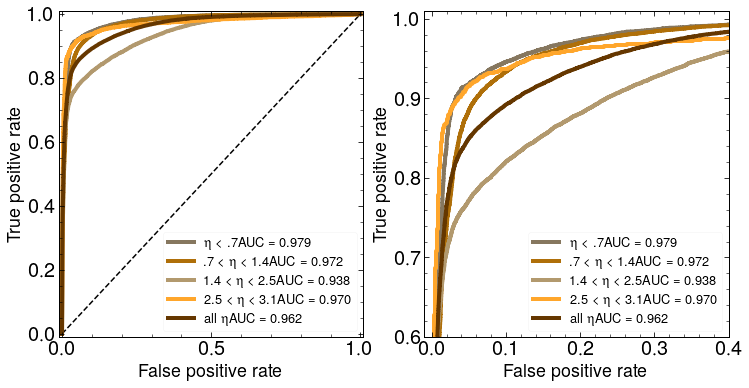

In [77]:
plots_complete(history_all, fp_all, tp_all, auc_all)

In [1]:
r = 1

In [57]:
t1 = [1,2,3,4,5]
t2=[5,4,3,2,1]

test = [t1, t2]

In [58]:
sel = [True, False, False, True, True]

test[sel]

TypeError: list indices must be integers or slices, not list

In [65]:
t_interm = [np.array(t1)[sel], np.array(t2)[sel]]

In [66]:
t_interm

[array([1, 4, 5]), array([5, 2, 1])]